This notebook was used to visualize and summarize the output of the severity scripts. The data is first loaded, global and regional summaries are computed. The data is then visualized using matplotlib and seaborn.

In [1]:
#import packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

In [2]:
#load data
file1 = "/lustre/backup/WUR/ESG/gohin001/Data/severity/historical_severity.nc"
file2 = "/lustre/backup/WUR/ESG/gohin001/Data/severity/ssp126_severity.nc"
file3 = "/lustre/backup/WUR/ESG/gohin001/Data/severity/ssp370_severity.nc"
file4 = "/lustre/backup/WUR/ESG/gohin001/Data/severity/ssp585_severity.nc"


historical = xr.open_dataset(file1)
ssp126 = xr.open_dataset(file2)
ssp370 = xr.open_dataset(file3)
ssp585 = xr.open_dataset(file4)


In [3]:
#load drought_flood data to compute masks
file1 = "/lustre/backup/WUR/ESG/gohin001/Data/drought_and_floods/historical_flood_drought_dis>100.nc"
file2 = "/lustre/backup/WUR/ESG/gohin001/Data/drought_and_floods/ssp126_drought_flood_dis>100.nc"
file3 = "/lustre/backup/WUR/ESG/gohin001/Data/drought_and_floods/ssp370_drought_flood_dis>100.nc"
historical_df = xr.open_dataset(file1)
ssp126_df = xr.open_dataset(file2)
ssp370_df = xr.open_dataset(file3)

historical['dis'] = historical_df['dis']
ssp126['dis'] = ssp126_df['dis']
ssp370['dis'] = ssp370_df['dis']

historical['mask'] = historical['dis'].groupby("time.year").mean(dim="time", skipna=True).mean(dim="year") > 100
ssp126['mask'] = ssp126['dis'].groupby("time.year").mean(dim="time", skipna=True).mean(dim="year") > 100
ssp370['mask'] = ssp370['dis'].groupby("time.year").mean(dim="time", skipna=True).mean(dim="year") > 100

In [3]:
# compute Mean ECSI severity across scenarios and event types

print("=== Mean ECSI Severity by Scenario and Event Type ===\n")

# DtoF
print("DtoF Events:")
print(f"  Historical: {historical['ECSI_sev_DtoF'].mean().item():.4f}")
print(f"  SSP1-2.6  : {ssp126['ECSI_sev_DtoF'].mean().item():.4f}")
print(f"  SSP3-7.0  : {ssp370['ECSI_sev_DtoF'].mean().item():.4f}")

# FtoD
print("FtoD Events:")
print(f"  Historical: {historical['ECSI_sev_FtoD'].mean().item():.4f}")
print(f"  SSP1-2.6  : {ssp126['ECSI_sev_FtoD'].mean().item():.4f}")
print(f"  SSP3-7.0  : {ssp370['ECSI_sev_FtoD'].mean().item():.4f}")

# D&F
print("D&F Events:")
print(f"  Historical: {historical['ECSI_sev_D&F'].mean(dim='events_sev').mean().item():.4f}")
print(f"  SSP1-2.6  : {ssp126['ECSI_sev_D&F'].mean(dim='events_sev').mean().item():.4f}")
print(f"  SSP3-7.0  : {ssp370['ECSI_sev_D&F'].mean(dim='events_sev').mean().item():.4f}")


=== Mean ECSI Severity by Scenario and Event Type ===

DtoF Events:
  Historical: 0.4085
  SSP1-2.6  : 0.4621
  SSP3-7.0  : 0.5114
FtoD Events:
  Historical: 0.4303
  SSP1-2.6  : 0.4693
  SSP3-7.0  : 0.5353
D&F Events:
  Historical: 0.4449
  SSP1-2.6  : 0.5202
  SSP3-7.0  : 0.5851


In [8]:
#compute global means across transition types
def define_transition_severity(ds, label):
    # FtoD transitions
    ds[f"ECSI_sev_FtoD_slow"] = xr.where(ds['transition_times_FtoD'] > 90, ds['ECSI_sev_FtoD'], np.nan)
    ds[f"ECSI_sev_FtoD_rapid"] = xr.where((ds['transition_times_FtoD'] > 30) & (ds['transition_times_FtoD'] <= 90), ds['ECSI_sev_FtoD'], np.nan)
    ds[f"ECSI_sev_FtoD_abrupt"] = xr.where(ds['transition_times_FtoD'] <= 30, ds['ECSI_sev_FtoD'], np.nan)

    # DtoF transitions
    ds[f"ECSI_sev_DtoF_slow"] = xr.where(ds['transition_times_DtoF'] > 90, ds['ECSI_sev_DtoF'], np.nan)
    ds[f"ECSI_sev_DtoF_rapid"] = xr.where((ds['transition_times_DtoF'] > 30) & (ds['transition_times_DtoF'] <= 90), ds['ECSI_sev_DtoF'], np.nan)
    ds[f"ECSI_sev_DtoF_abrupt"] = xr.where(ds['transition_times_DtoF'] <= 30, ds['ECSI_sev_DtoF'], np.nan)

    print(f"\n=== Mean ECSI Severity for {label} Scenario ===")
    
    print("FtoD Events:")
    print(f"  Slow   : {ds['ECSI_sev_FtoD_slow'].mean().item():.4f}")
    print(f"  Rapid  : {ds['ECSI_sev_FtoD_rapid'].mean().item():.4f}")
    print(f"  Abrupt : {ds['ECSI_sev_FtoD_abrupt'].mean().item():.4f}")
    
    print("DtoF Events:")
    print(f"  Slow   : {ds['ECSI_sev_DtoF_slow'].mean().item():.4f}")
    print(f"  Rapid  : {ds['ECSI_sev_DtoF_rapid'].mean().item():.4f}")
    print(f"  Abrupt : {ds['ECSI_sev_DtoF_abrupt'].mean().item():.4f}")

# Apply to each dataset
define_transition_severity(historical, "Historical")
define_transition_severity(ssp126, "SSP1-2.6")
define_transition_severity(ssp370, "SSP3-7.0")


In [4]:
#compute global mean drought duration
scenarios = {
    "Historical": historical, 
    "SSP1-2.6": ssp126, 
    "SSP3-7.0": ssp370,
}
for scenario_name, scenario in scenarios.items():
    print(f'{scenario_name} for DtoF : {scenario["duration_DtoF"].mean()}')
    print(f'{scenario_name} for D&F : {scenario["duration_D&F"].mean()}')
    print(f'{scenario_name} for FtoD : {scenario["duration_FtoD"].mean()}')


Historical for DtoF : <xarray.DataArray 'duration_DtoF' ()> Size: 8B
array(66.37924996)
Coordinates:
    quantile  float64 8B 0.15
Historical for D&F : <xarray.DataArray 'duration_D&F' ()> Size: 8B
array(51.3892211)
Coordinates:
    quantile  float64 8B 0.15
Historical for FtoD : <xarray.DataArray 'duration_FtoD' ()> Size: 8B
array(64.01390947)
Coordinates:
    quantile  float64 8B 0.15
SSP1-2.6 for DtoF : <xarray.DataArray 'duration_DtoF' ()> Size: 8B
array(65.31169599)
Coordinates:
    quantile  float64 8B 0.15
SSP1-2.6 for D&F : <xarray.DataArray 'duration_D&F' ()> Size: 8B
array(55.82818861)
Coordinates:
    quantile  float64 8B 0.15
SSP1-2.6 for FtoD : <xarray.DataArray 'duration_FtoD' ()> Size: 8B
array(59.9430414)
Coordinates:
    quantile  float64 8B 0.15
SSP3-7.0 for DtoF : <xarray.DataArray 'duration_DtoF' ()> Size: 8B
array(69.04145849)
Coordinates:
    quantile  float64 8B 0.15
SSP3-7.0 for D&F : <xarray.DataArray 'duration_D&F' ()> Size: 8B
array(58.29500907)
Coordinates:


In [3]:
#compute global mean drought duration across transition types
scenarios = {
    "Historical": historical, 
    "SSP1-2.6": ssp126, 
    "SSP3-7.0": ssp370,
}
for scenario_name, scenario in scenarios.items():
    print(f'drought duration {scenario_name} for all DtoF : {scenario["duration_DtoF"].mean()}')
    print(f'drought duration {scenario_name} for all FtoD : {scenario["duration_FtoD"].mean()}')
          
    print(f'drought duration {scenario_name} for moderate DtoF : {scenario["duration_DtoF_mod"].mean()}')
    print(f'drought duration {scenario_name} for moderate FtoD : {scenario["duration_FtoD_mod"].mean()}')

    print(f'drought duration {scenario_name} for rapid DtoF : {scenario["duration_DtoF_rap"].mean()}')
    print(f'drought duration {scenario_name} for rapid FtoD : {scenario["duration_FtoD_rap"].mean()}')

    print(f'drought duration {scenario_name} for abrupt DtoF : {scenario["duration_DtoF_abr"].mean()}')
    print(f'drought duration {scenario_name} for abrupt FtoD : {scenario["duration_FtoD_abr"].mean()}')
    
    print(f'drought duration {scenario_name} for D&F : {scenario["duration_D&F"].mean()}')


drought duration Historical for all DtoF : <xarray.DataArray 'duration_DtoF' ()> Size: 8B
array(66.37924996)
Coordinates:
    quantile  float64 8B ...
drought duration Historical for all FtoD : <xarray.DataArray 'duration_FtoD' ()> Size: 8B
array(64.01390947)
Coordinates:
    quantile  float64 8B ...
drought duration Historical for moderate DtoF : <xarray.DataArray 'duration_DtoF_mod' ()> Size: 8B
array(56.33594862)
Coordinates:
    quantile  float64 8B ...
drought duration Historical for moderate FtoD : <xarray.DataArray 'duration_FtoD_mod' ()> Size: 8B
array(67.32188047)
Coordinates:
    quantile  float64 8B ...
drought duration Historical for rapid DtoF : <xarray.DataArray 'duration_DtoF_rap' ()> Size: 8B
array(73.6594227)
Coordinates:
    quantile  float64 8B ...
drought duration Historical for rapid FtoD : <xarray.DataArray 'duration_FtoD_rap' ()> Size: 8B
array(64.25031711)
Coordinates:
    quantile  float64 8B ...
drought duration Historical for abrupt DtoF : <xarray.DataArray '

In [3]:
#explored drought duration further
scenarios = {
    "Historical": historical, 
    "SSP1-2.6": ssp126, 
    "SSP3-7.0": ssp370,
}
for scenario_name, scenario in scenarios.items():
    print(f'drought duration {scenario_name} for all DtoF : {scenario["duration_DtoF"].quantile(0.95)}')
    print(f'drought duration {scenario_name} for all FtoD : {scenario["duration_FtoD"].quantile(0.95)}')
          
    print(f'drought duration {scenario_name} for moderate DtoF : {scenario["duration_DtoF_mod"].quantile(0.95)}')
    print(f'drought duration {scenario_name} for moderate FtoD : {scenario["duration_FtoD_mod"].quantile(0.95)}')

    print(f'drought duration {scenario_name} for rapid DtoF : {scenario["duration_DtoF_rap"].quantile(0.95)}')
    print(f'drought duration {scenario_name} for rapid FtoD : {scenario["duration_FtoD_rap"].quantile(0.95)}')

    print(f'drought duration {scenario_name} for abrupt DtoF : {scenario["duration_DtoF_abr"].quantile(0.95)}')
    print(f'drought duration {scenario_name} for abrupt FtoD : {scenario["duration_FtoD_abr"].quantile(0.95)}')
    
    print(f'drought duration {scenario_name} for D&F : {scenario["duration_D&F"].quantile(0.95)}')


drought duration Historical for all DtoF : <xarray.DataArray 'duration_DtoF' ()> Size: 8B
array(194.)
Coordinates:
    quantile  float64 8B 0.95
drought duration Historical for all FtoD : <xarray.DataArray 'duration_FtoD' ()> Size: 8B
array(191.8)
Coordinates:
    quantile  float64 8B 0.95
drought duration Historical for moderate DtoF : <xarray.DataArray 'duration_DtoF_mod' ()> Size: 8B
array(144.)
Coordinates:
    quantile  float64 8B 0.95
drought duration Historical for moderate FtoD : <xarray.DataArray 'duration_FtoD_mod' ()> Size: 8B
array(191.)
Coordinates:
    quantile  float64 8B 0.95
drought duration Historical for rapid DtoF : <xarray.DataArray 'duration_DtoF_rap' ()> Size: 8B
array(202.)
Coordinates:
    quantile  float64 8B 0.95
drought duration Historical for rapid FtoD : <xarray.DataArray 'duration_FtoD_rap' ()> Size: 8B
array(217.)
Coordinates:
    quantile  float64 8B 0.95
drought duration Historical for abrupt DtoF : <xarray.DataArray 'duration_DtoF_abr' ()> Size: 8B
ar

In [ ]:
#define flood magnitude for all transition types
scenarios = {
    "Historical": historical,
    "SSP1-2.6": ssp126, 
    "SSP3-7.0": ssp370,


    
}


for scenario in scenarios.values():
    scenario["magnitude_flood_FtoD_mod"] = xr.where(scenario['transition_times_FtoD'] > 90, scenario['magnitude_flood_FtoD'], np.nan)
    scenario["magnitude_flood_FtoD_rap"] = xr.where((scenario['transition_times_FtoD'] <= 90) & (scenario['transition_times_FtoD'] > 30), scenario['magnitude_flood_FtoD'], np.nan)
    scenario["magnitude_flood_FtoD_abr"] = xr.where((scenario['transition_times_FtoD'] <= 30), scenario['magnitude_flood_FtoD'], np.nan)
    
    scenario["magnitude_flood_DtoF_mod"] = xr.where(scenario['transition_times_DtoF'] > 90, scenario['magnitude_flood_DtoF'], np.nan)
    scenario["magnitude_flood_DtoF_rap"] = xr.where((scenario['transition_times_DtoF'] <= 90) & (scenario['transition_times_DtoF'] > 30), scenario['magnitude_flood_DtoF'], np.nan)
    scenario["magnitude_flood_DtoF_abr"] = xr.where((scenario['transition_times_DtoF'] <= 30), scenario['magnitude_flood_DtoF'], np.nan)




In [ ]:
#compute global mean flood magnitudes for all event/transition types across all scenarios
for scenario_name, scenario in scenarios.items():
    print(f'flood magnitude {scenario_name} for all DtoF : {scenario["magnitude_flood_DtoF"].mean()}')
    print(f'flood magnitude {scenario_name} for all FtoD : {scenario["magnitude_flood_FtoD"].mean()}')
          
    print(f'flood magnitude {scenario_name} for moderate DtoF : {scenario["magnitude_flood_DtoF_mod"].mean()}')
    print(f'flood magnitude {scenario_name} for moderate FtoD : {scenario["magnitude_flood_FtoD_mod"].mean()}')

    print(f'flood magnitude {scenario_name} for rapid DtoF : {scenario["magnitude_flood_DtoF_rap"].mean()}')
    print(f'flood magnitude {scenario_name} for rapid FtoD : {scenario["magnitude_flood_FtoD_rap"].mean()}')

    print(f'flood magnitude {scenario_name} for abrupt DtoF : {scenario["magnitude_flood_DtoF_abr"].mean()}')
    print(f'flood magnitude {scenario_name} for abrupt FtoD : {scenario["magnitude_flood_FtoD_abr"].mean()}')
    
    print(f'flood magnitude {scenario_name} for D&F : {scenario["magnitude_flood_D&F"].mean()}')



/tmp/ipykernel_3389195/618749177.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 1], pad=1.5)


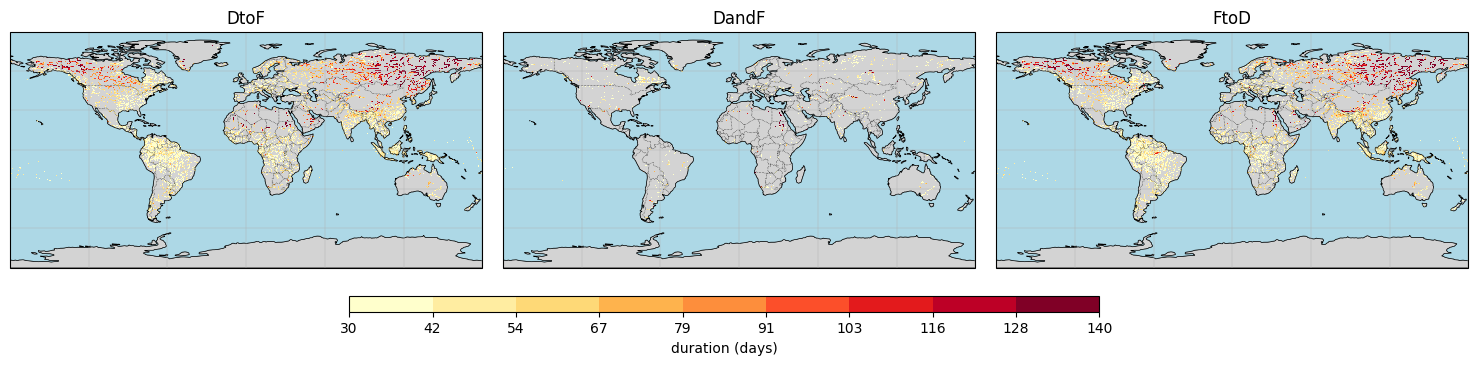

In [60]:
#create map for historical drought duration across CFD event types

# Define scenarios
scenarios = {
    "Historical": historical, 
}

# Define event types
event_types = ["DtoF", "DandF", "FtoD"]

# Define a continuous colormap
cmap = plt.cm.YlOrRd  # Yellow to Red/Orange colormap

# Define boundaries for the colorbar
bounds = np.linspace(30,140,10).round(0)
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalize colors to data range

# Create figure and subplots (rows: scenarios, cols: event types)
fig, axes = plt.subplots(nrows=len(scenarios), ncols=len(event_types),
                         figsize=(15, 12), subplot_kw={"projection": ccrs.PlateCarree()})

# Create a colorbar axis
cbar_ax = fig.add_axes([0.24, 0.39, 0.5, 0.013])

# Loop through scenarios and event types
for (scenario_name, scenario) in scenarios.items():
    for j, event in enumerate(event_types):
        ax = axes[j]
        
        # Extract the correct dataset
        if event == "DtoF":
            data = scenario['duration_DtoF'].mean(dim='events_duration', skipna=True)
        elif event == "DandF":
            data = scenario['duration_D&F'].mean(dim='events_duration', skipna=True)
        elif event == "FtoD":
            data = scenario['duration_FtoD'].mean(dim='events_duration', skipna=True)
        
        # Add map features with thinner outlines
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)  # Thin coastline
        ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.4)  # Thin borders
        ax.add_feature(cfeature.LAND, facecolor = "lightgray", edgecolor="black", linewidth=0.3) 
        ax.add_feature(cfeature.OCEAN, facecolor="lightblue")  # Light gray ocean for better contrast

        img = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, add_labels=False)

        ax.set_title("")  
        ax.set_title(event, fontsize=12)


        # Remove gridlines and ticks
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        ax.gridlines(linewidth = 0.3, draw_labels=False)  # Remove gridline labels

plt.subplots_adjust(hspace=-0.6)
# Add a single colorbar
fig.colorbar(img, cax=cbar_ax, location = "bottom", label="duration (days)")
plt.tight_layout(rect=[0, 0.05, 1, 1], pad=1.5) 
plt.savefig(
    "drought_duration_noantartica.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    pad_inches=0.05 
)
plt.show()


/tmp/ipykernel_3389195/4025417931.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.5)
/tmp/ipykernel_3389195/4025417931.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


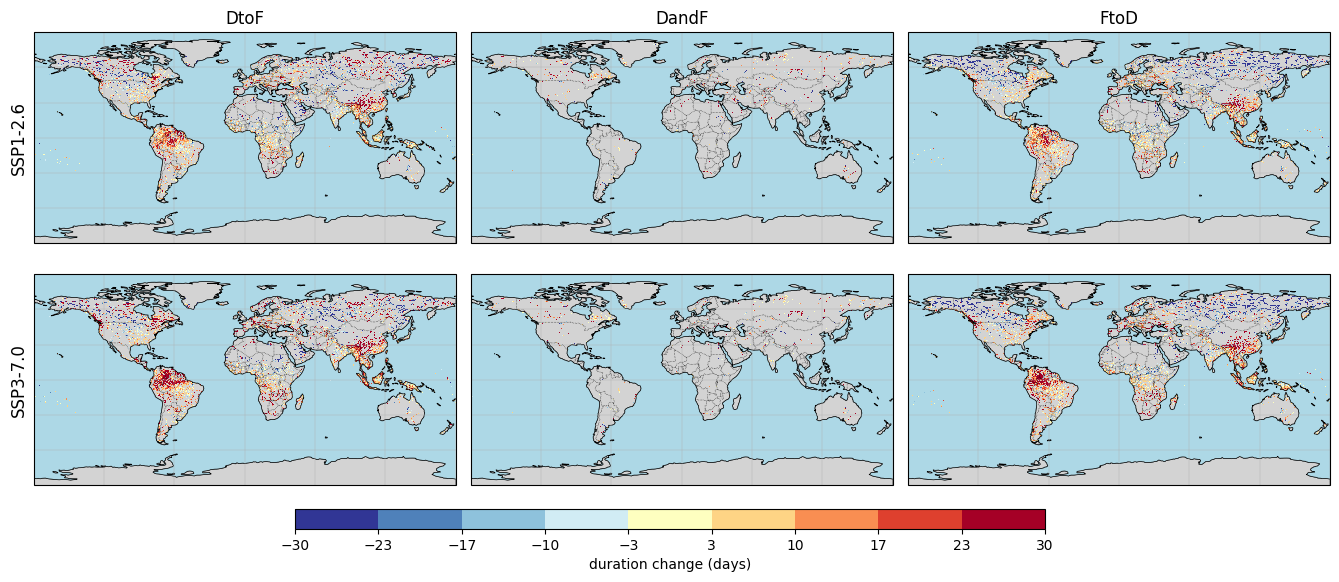

In [67]:
#create maps for drought duration change in future scenarios across CFD event types
# Define scenarios
scenarios = {
    "SSP1-2.6": ssp126, 
    "SSP3-7.0": ssp370,
}

# Define event types
event_types = ["DtoF", "DandF", "FtoD"]

# Define a continuous colormap
cmap = plt.cm.RdYlBu_r # Yellow to Red/Orange colormap

# Define boundaries for the colorbar
bounds = np.linspace(-30,30,10).round(0)
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalize colors to data range

# Create figure and subplots (rows: scenarios, cols: event types)
fig, axes = plt.subplots(nrows=len(scenarios), ncols=len(event_types),
                         figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Create a colorbar axis
cbar_ax = fig.add_axes([0.2, 0.23, 0.5, 0.02])

# Loop through scenarios and event types
for i, (scenario_name, scenario) in enumerate(scenarios.items()):
    for j, event in enumerate(event_types):
        ax = axes[i, j]
        
        # Extract the correct dataset
        if event == "DtoF":
            data = scenario['duration_DtoF'].mean(dim='events_duration', skipna=True) - historical['duration_DtoF'].mean(dim='events_duration', skipna=True)
        elif event == "DandF":
            data = scenario['duration_D&F'].mean(dim='events_duration', skipna=True) - historical['duration_D&F'].mean(dim='events_duration', skipna=True)
        elif event == "FtoD":
            data = scenario['duration_FtoD'].mean(dim='events_duration', skipna=True) - historical['duration_FtoD'].mean(dim='events_duration', skipna=True)
        
        # Add map features with thinner outlines
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)  # Thin coastline
        ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.4)  # Thin borders
        ax.add_feature(cfeature.LAND, facecolor = "lightgray", edgecolor="black", linewidth=0.3)  # Thin land outline
        ax.add_feature(cfeature.OCEAN, facecolor="lightblue")  # Light gray ocean for better contrast

        # Plot data
        img = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, add_labels=False)

        # Remove auto-generated title
        ax.set_title("")  

        # Title for columns
        if i == 0:
            ax.set_title(event, fontsize=12)

        # Label rows
        if j == 0:
            ax.set_ylabel(scenario_name, fontsize=12)

        # Remove gridlines and ticks
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        #ax.set_xlabel("")
        #ax.set_ylabel("")
        ax.gridlines(linewidth = 0.3, draw_labels=False)  # Remove gridline labels

plt.subplots_adjust(hspace=-0.9)
# Add a single colorbar
fig.colorbar(img, cax=cbar_ax, location = "bottom", label="duration change (days)")

plt.tight_layout(pad=1.5)
plt.tight_layout(rect=[0, 0, 0.9, 1]) 
plt.savefig(
    "drought_duration_change.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    pad_inches=0.05 
)
plt.show()


/tmp/ipykernel_60691/947661623.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.5)
/tmp/ipykernel_60691/947661623.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


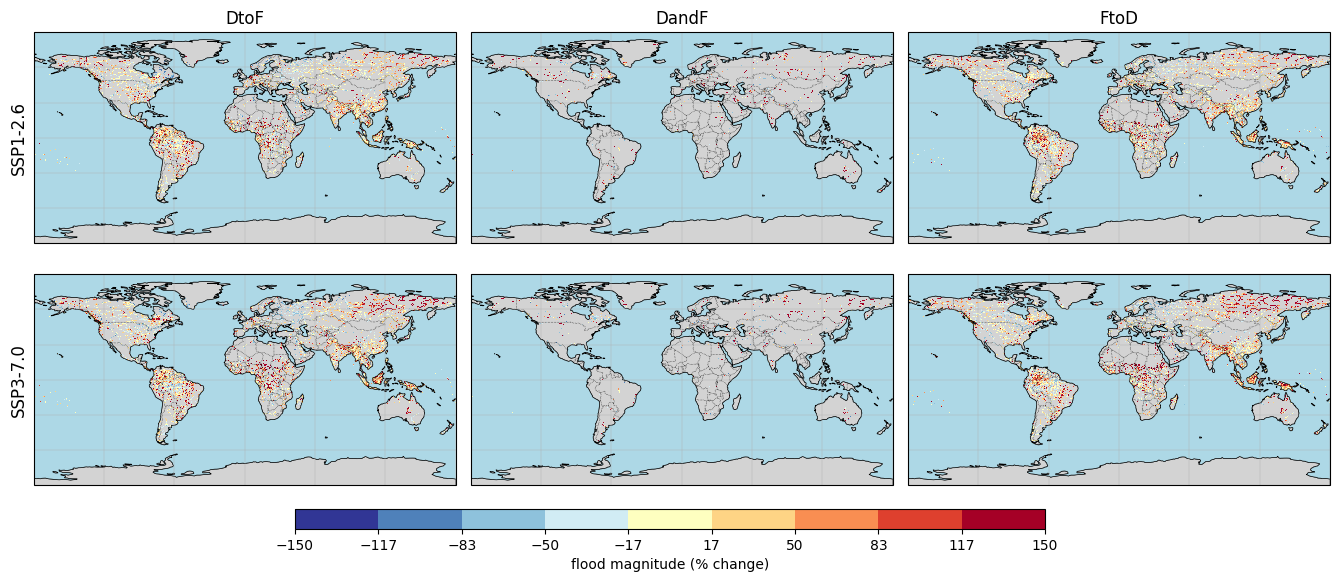

In [7]:
#create map for flood magnitude change in future scenarios and across all CFD event types

# Define a continuous colormap
cmap = plt.cm.RdYlBu_r  # Yellow to Red/Orange colormap

# Define boundaries for the colorbar
bounds = np.linspace(-150,150,10).round(0)
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalize colors to data range

# Create figure and subplots (rows: scenarios, cols: event types)
fig, axes = plt.subplots(nrows=len(scenarios), ncols=len(event_types),
                         figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Create a colorbar axis
cbar_ax = fig.add_axes([0.2, 0.23, 0.5, 0.02])

# Loop through scenarios and event types
for i, (scenario_name, scenario) in enumerate(scenarios.items()):
    for j, event in enumerate(event_types):
        ax = axes[i, j]
        
        # Extract the correct dataset
        if event == "DtoF":
            data = ((scenario['magnitude_flood_DtoF'].mean(dim='events_sev') - historical['magnitude_flood_DtoF'].mean(dim='events_sev'))/historical['magnitude_flood_DtoF'].mean(dim='events_sev'))*100
        elif event == "DandF":
            data = ((scenario['magnitude_flood_D&F'].mean(dim='events_sev') - historical['magnitude_flood_D&F'].mean(dim='events_sev'))/historical['magnitude_flood_D&F'].mean(dim='events_sev'))*100
        elif event == "FtoD":
            data = ((scenario['magnitude_flood_FtoD'].mean(dim='events_sev') - historical['magnitude_flood_FtoD'].mean(dim='events_sev'))/historical['magnitude_flood_FtoD'].mean(dim='events_sev'))*100
        
        # Add map features with  outlines
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)  
        ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.4) 
        ax.add_feature(cfeature.LAND, facecolor = "lightgray", edgecolor="black", linewidth=0.3)  
        ax.add_feature(cfeature.OCEAN, facecolor="lightblue") 

        # Plot data
        img = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, add_labels = False)

        # Remove auto-generated title
        ax.set_title("")  

        # Title for columns
        if i == 0:
            ax.set_title(event, fontsize=12)

        # Label rows
        if j == 0:
            ax.set_ylabel(scenario_name, fontsize=12)

        # Remove gridlines and ticks
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        #ax.set_xlabel("")
        #ax.set_ylabel("")
        ax.gridlines(linewidth = 0.3, draw_labels=False)  # Remove gridline labels

plt.subplots_adjust(hspace=-0.9)
# Add a single colorbar
fig.colorbar(img, cax=cbar_ax, location = "bottom", label="flood magnitude (% change)")

plt.tight_layout(pad=1.5)
plt.tight_layout(rect=[0, 0, 0.9, 1]) 
plt.savefig(
    "flood_magnitude_change.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    pad_inches=0.05  
)
plt.show()


/tmp/ipykernel_810461/3505969801.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.5)
/tmp/ipykernel_810461/3505969801.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


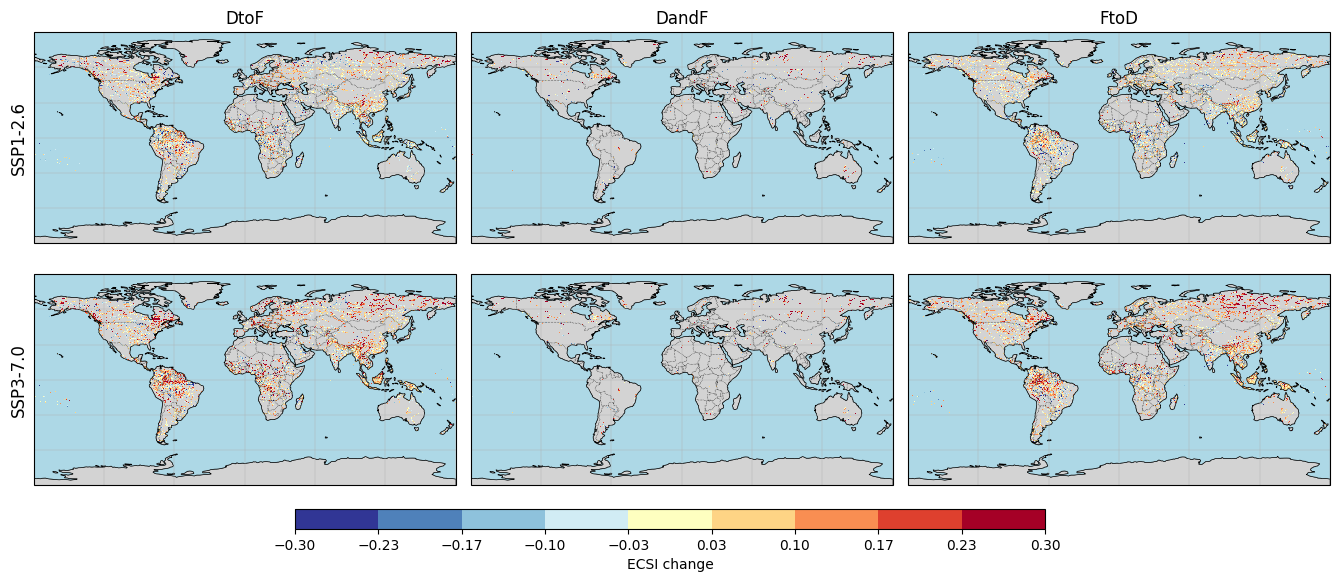

In [16]:
#create maps for ECSI change in future scenarios across CFD event types


# Define a continuous colormap
cmap = plt.cm.RdYlBu_r  # Yellow to Red/Orange colormap

# Define boundaries for the colorbar
bounds = np.linspace(-0.3,0.3,10).round(2)
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalize colors to data range

# Create figure and subplots (rows: scenarios, cols: event types)
fig, axes = plt.subplots(nrows=len(scenarios), ncols=len(event_types),
                         figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Create a colorbar axis
cbar_ax = fig.add_axes([0.2, 0.23, 0.5, 0.02])

# Loop through scenarios and event types
for i, (scenario_name, scenario) in enumerate(scenarios.items()):
    for j, event in enumerate(event_types):
        ax = axes[i, j]
        
        # Extract the correct dataset
        if event == "DtoF":
            data = scenario['ECSI_sev_DtoF'].mean(dim='events_sev') - historical['ECSI_sev_DtoF'].mean(dim='events_sev')
        elif event == "DandF":
            data = scenario['ECSI_sev_D&F'].mean(dim='events_sev') - historical['ECSI_sev_D&F'].mean(dim='events_sev')
        elif event == "FtoD":
            data = scenario['ECSI_sev_FtoD'].mean(dim='events_sev') - historical['ECSI_sev_FtoD'].mean(dim='events_sev')
        
        # Add map features with  outlines
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5) 
        ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.4) 
        ax.add_feature(cfeature.LAND, facecolor = "lightgray", edgecolor="black", linewidth=0.3)  
        ax.add_feature(cfeature.OCEAN, facecolor="lightblue") 

        # Plot data
        img = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, add_labels = False)

        # Remove auto-generated title
        ax.set_title("")  

        # Title for columns
        if i == 0:
            ax.set_title(event, fontsize=12)

        # Label rows
        if j == 0:
            ax.set_ylabel(scenario_name, fontsize=12)

        # Remove gridlines and ticks
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        #ax.set_xlabel("")
        #ax.set_ylabel("")
        ax.gridlines(linewidth = 0.3, draw_labels=False)  # Remove gridline labels

plt.subplots_adjust(hspace=-0.9)
# Add a single colorbar
fig.colorbar(img, cax=cbar_ax, location = "bottom", label="ECSI change")

plt.tight_layout(pad=1.5)
plt.tight_layout(rect=[0, 0, 0.9, 1]) 
plt.savefig(
    "ECSI_change.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    pad_inches=0.05  
)
plt.show()


In [18]:
### define regions
#North America
historical_NA = historical.sel(lat=slice(75, 15), lon=slice(-170, -50))
ssp126_NA = ssp126.sel(lat=slice(75, 15), lon=slice(-170, -50))
ssp370_NA = ssp370.sel(lat=slice(75, 15), lon=slice(-170, -50))

#South America
historical_SA = historical.sel(lat=slice(15, -60), lon=slice(-85, -30))
ssp126_SA = ssp126.sel(lat=slice(15, -60), lon=slice(-85, -30))
ssp370_SA = ssp370.sel(lat=slice(15, -60), lon=slice(-85, -30))

#Europe
historical_europe = historical.sel(lat=slice(72, 35), lon=slice(-25, 45))
ssp126_europe = ssp126.sel(lat=slice(72, 35), lon=slice(-25, 45))
ssp370_europe = ssp370.sel(lat=slice(72, 35), lon=slice(-25, 45))

#Subsahran Africa
historical_SSA = historical.sel(lat=slice(15, -35), lon=slice(-20, 55))
ssp126_SSA = ssp126.sel(lat=slice(15, -35), lon=slice(-20, 55))
ssp370_SSA = ssp370.sel(lat=slice(15, -35), lon=slice(-20, 55))

#NA/ME
historical_NA_ME = historical.sel(lat=slice(37, 15), lon=slice(-20, 60))
ssp126_NA_ME = ssp126.sel(lat=slice(37, 15), lon=slice(-20, 60))
ssp370_NA_ME = ssp370.sel(lat=slice(37, 15), lon=slice(-20, 60))

#central and northern Asia
historical_CNA = historical.sel(lat=slice(75, 35), lon=slice(40, 140))
ssp126_CNA = ssp126.sel(lat=slice(75, 35), lon=slice(40, 140))
ssp370_CNA = ssp370.sel(lat=slice(75, 35), lon=slice(40, 140))

#South East Asia
historical_SEA = historical.sel(lat=slice(35, -10), lon=slice(65, 135))
ssp126_SEA = ssp126.sel(lat=slice(35, -10), lon=slice(65, 135))
ssp370_SEA = ssp370.sel(lat=slice(35, -10), lon=slice(65, 135))

#Oceania
historical_Oce = historical.sel(lat=slice(0, -50), lon=slice(110, 180))
ssp126_Oce = ssp126.sel(lat=slice(0, -50), lon=slice(110, 180))
ssp370_Oce = ssp370.sel(lat=slice(0, -50), lon=slice(110, 180))                      

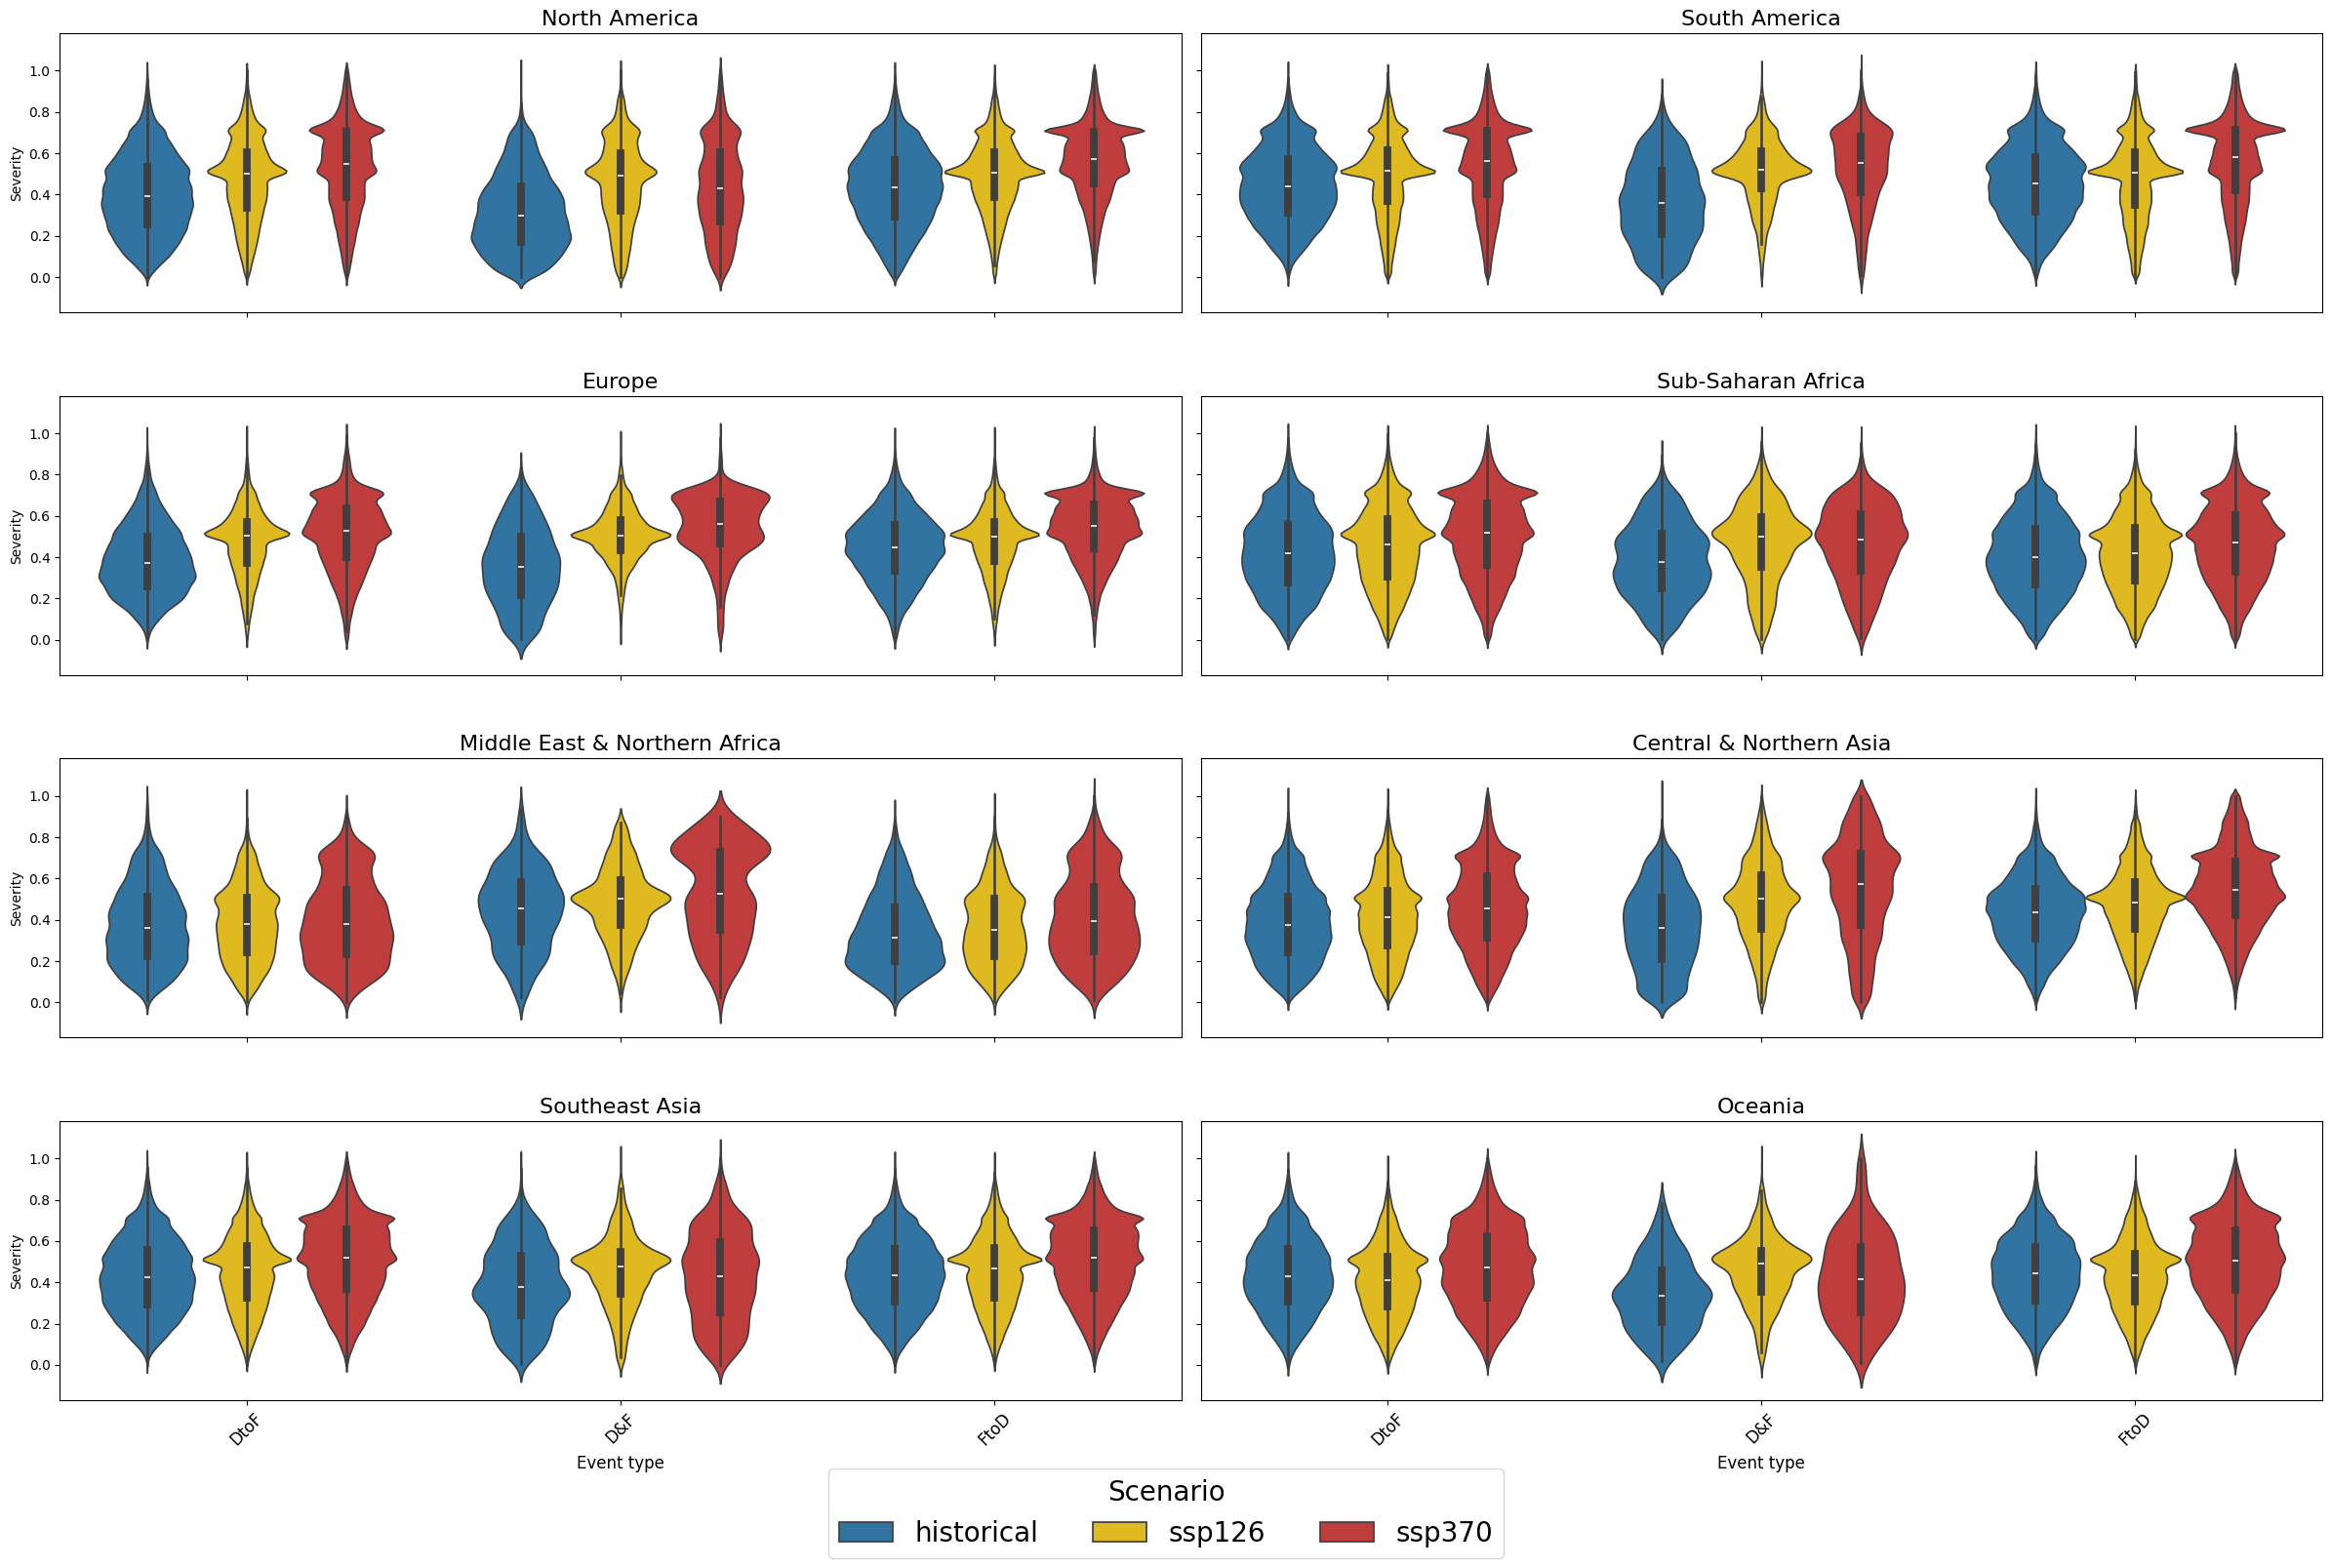

In [10]:
#create ECSI figure using seaborn across historical and future scenarios and for all CFD event types
# Define color palette
custom_palette = {
    "historical": "#1f77b4",  # blue
    "ssp126": "#ffcc00",      # yellow
    "ssp370": "#d62728"       # red
}

# Define regions and their datasets
regions = {
    "North America": [historical_NA, ssp126_NA, ssp370_NA],
    "South America": [historical_SA, ssp126_SA, ssp370_SA],
    "Europe": [historical_europe, ssp126_europe, ssp370_europe],
    "Sub-Saharan Africa": [historical_SSA, ssp126_SSA, ssp370_SSA],
    "Middle East & Northern Africa": [historical_NA_ME, ssp126_NA_ME, ssp370_NA_ME],
    "Central & Northern Asia": [historical_CNA, ssp126_CNA, ssp370_CNA],
    "Southeast Asia": [historical_SEA, ssp126_SEA, ssp370_SEA],
    "Oceania": [historical_Oce, ssp126_Oce, ssp370_Oce]
}

scenarios = ["historical", "ssp126", "ssp370"]
event_types = ["DtoF", "D&F", "FtoD"]

# Prep the plotting
fig, axes = plt.subplots(4, 2, figsize=(24, 16), sharey=True)
axes = axes.flatten()

# Go through each region
for idx, (region_name, datasets) in enumerate(regions.items()):
    ax = axes[idx]
    plot_data = []

    for scen_idx, dataset in enumerate(datasets):
        for event_type in event_types:
            var_name = f"ECSI_sev_{event_type}"
            if var_name in dataset:
                severity_data = dataset[var_name].values.flatten()
                severity_data = severity_data[~np.isnan(severity_data)]
                plot_data.append({
                    "region": region_name,
                    "scenario": scenarios[scen_idx],
                    "event_type": event_type,
                    "severity": severity_data
                })

    # Convert to long format for seaborn
    plot_df = []
    for item in plot_data:
        for val in item["severity"]:
            plot_df.append({
                "Scenario": item["scenario"],
                "EventType": item["event_type"],
                "Region": item["region"],
                "Severity": val
            })
    plot_df = pd.DataFrame(plot_df)

    sns.violinplot(data=plot_df, x="EventType", y="Severity", hue="Scenario",
                   ax=ax, palette=custom_palette)
    ax.set_title(region_name, fontsize = 16)

    # Remove x-axis labels except for bottom row
    if idx < 6:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Event type', fontsize = 12)
        ax.tick_params(axis='x', rotation=45, labelsize = 12)

    # Remove individual legends
    ax.get_legend().remove()

# Global legend at bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.01),
    ncol=len(handles),
    title="Scenario",
    fontsize=20,      
    title_fontsize=20   
)

# Adjust spacing
fig.tight_layout()
plt.subplots_adjust(hspace=0.3, bottom=0.1)
plt.savefig(
    "ECSI_by_region.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    pad_inches=0.05 
)
plt.show()


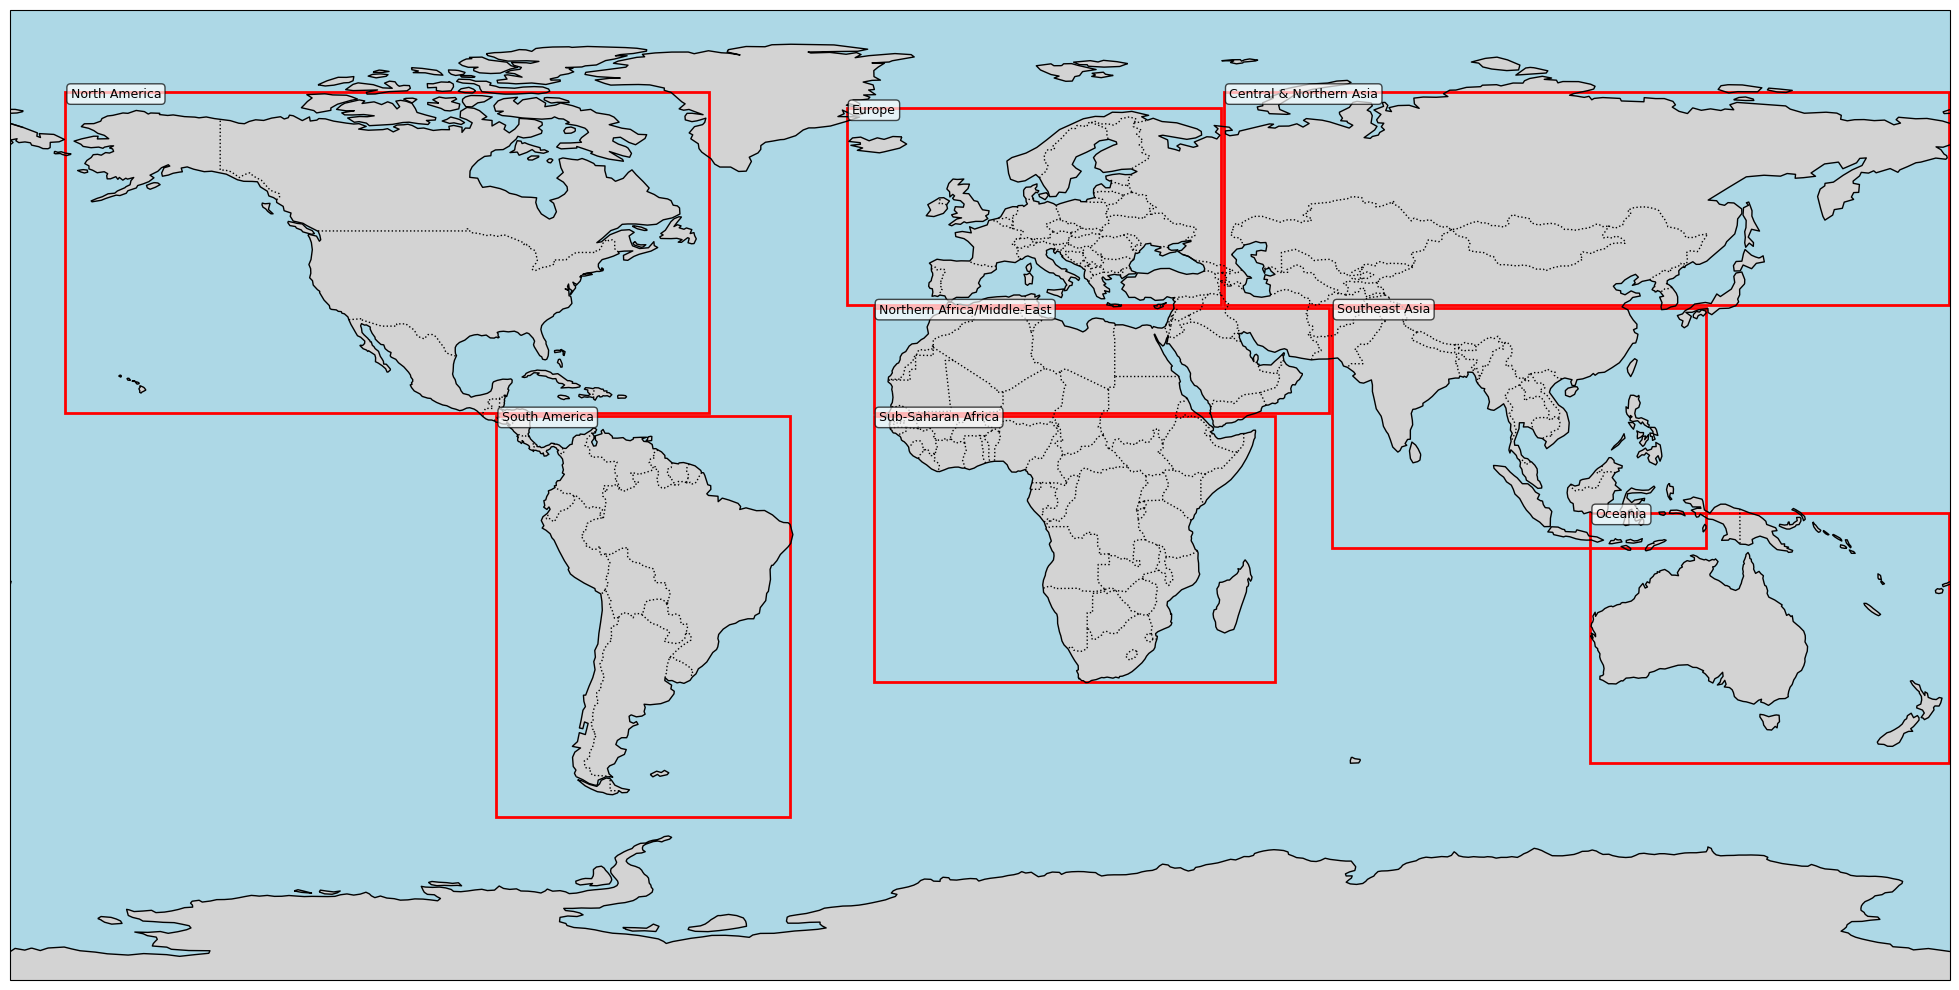

In [37]:
#create map for regional mapek-up
regions = {"North America": historical_NA,
    "South America": historical_SA,
    "Europe":       historical_europe,
    "Sub-Saharan Africa": historical_SSA,
    "Northern Africa/Middle-East": historical_NA_ME,
    "Central & Northern Asia":     historical_CNA,
    "Southeast Asia":              historical_SEA,
    "Oceania":                     historical_Oce
}

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add base map features
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Loop over regions and draw rectangle
for region_name, region in regions.items():
    mask = region["mask"]
    
    lon_min = float(mask.lon.min())
    lon_max = float(mask.lon.max())
    lat_min = float(mask.lat.min())
    lat_max = float(mask.lat.max())
    
    # Width and height for rectangle
    width = lon_max - lon_min
    height = lat_max - lat_min

    # Add rectangle
    rect = Rectangle((lon_min, lat_min), width, height,
                     linewidth=2, edgecolor='red', facecolor='none',
                     transform=ccrs.PlateCarree())
    ax.add_patch(rect)
    
    # Add label near the top-left of each rectangle
    ax.text(lon_min + 1, lat_max - 1, region_name, fontsize=9,
            color='black', transform=ccrs.PlateCarree(),
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))


plt.tight_layout()
plt.savefig(
    "regions",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    pad_inches=0.05  # Minimal external padding
)
plt.show()


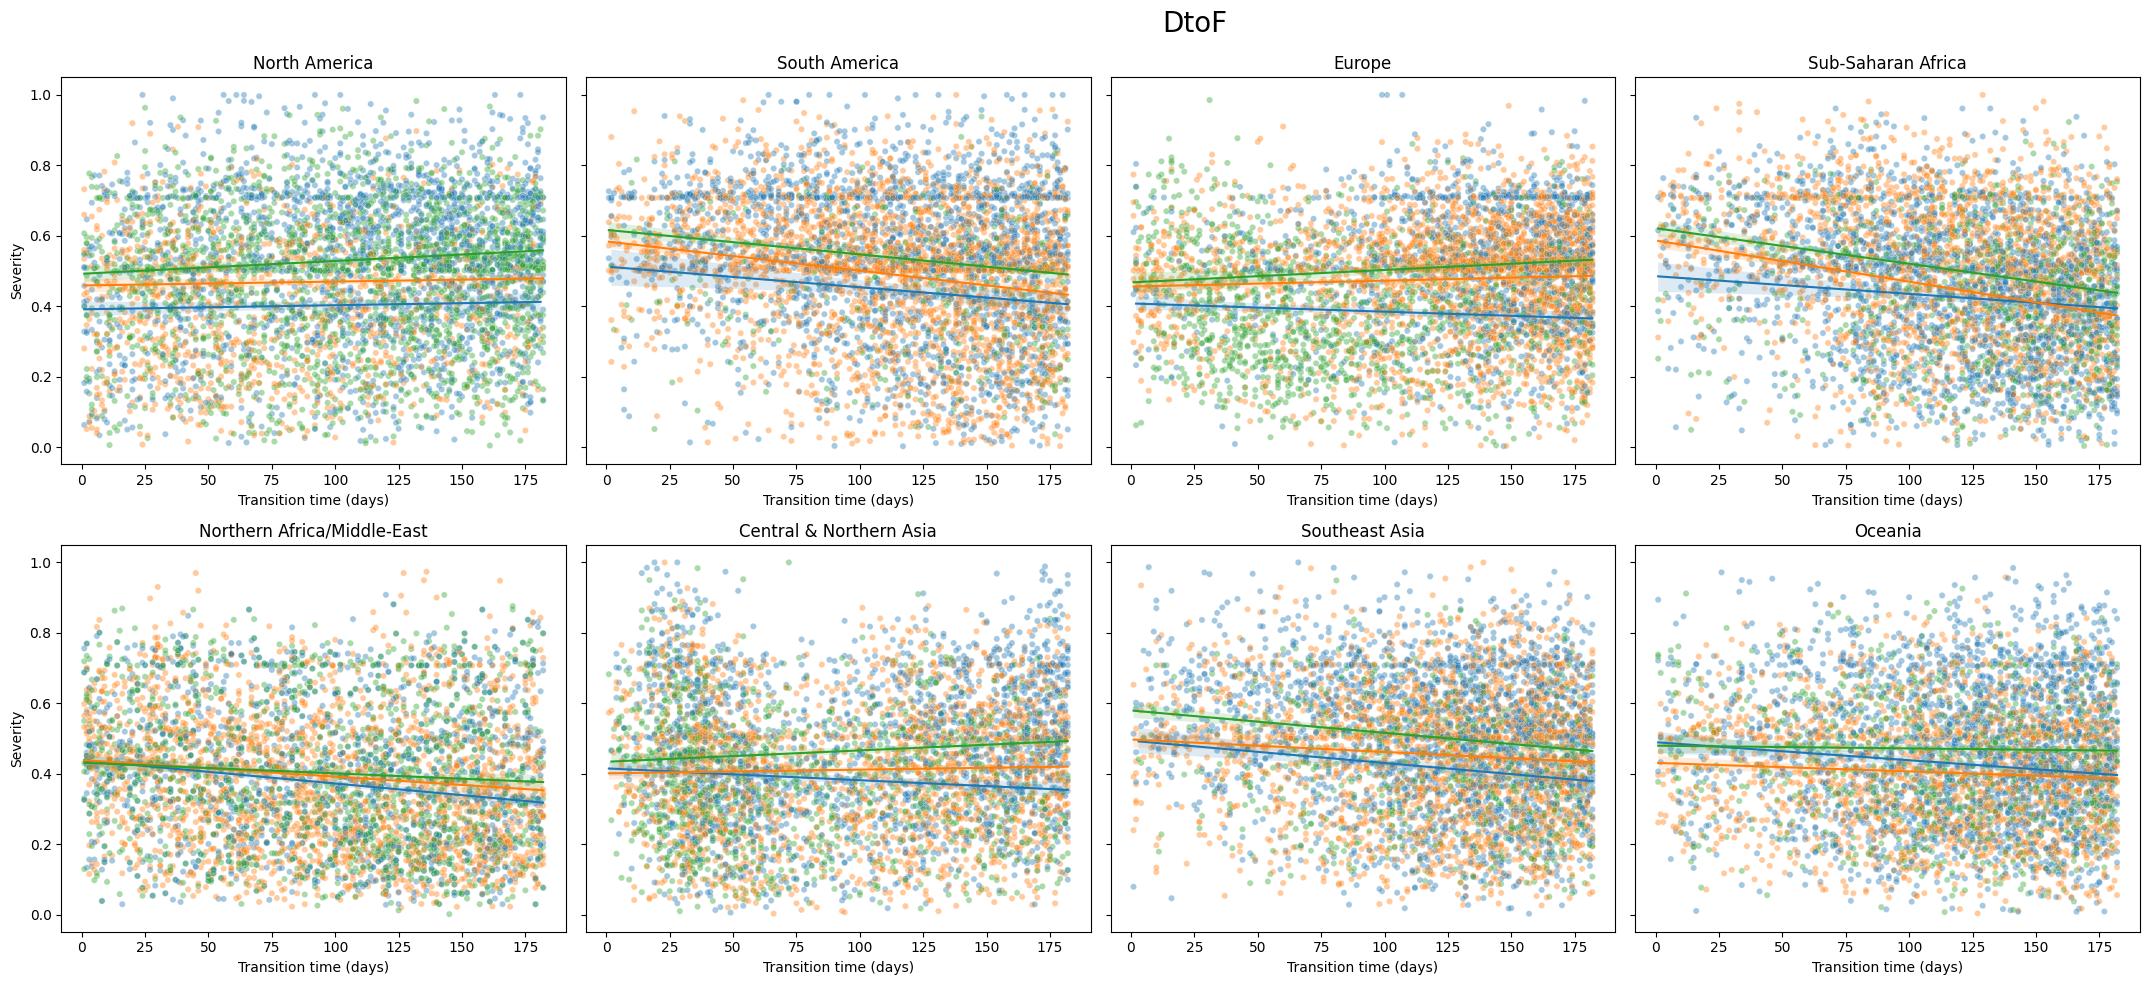

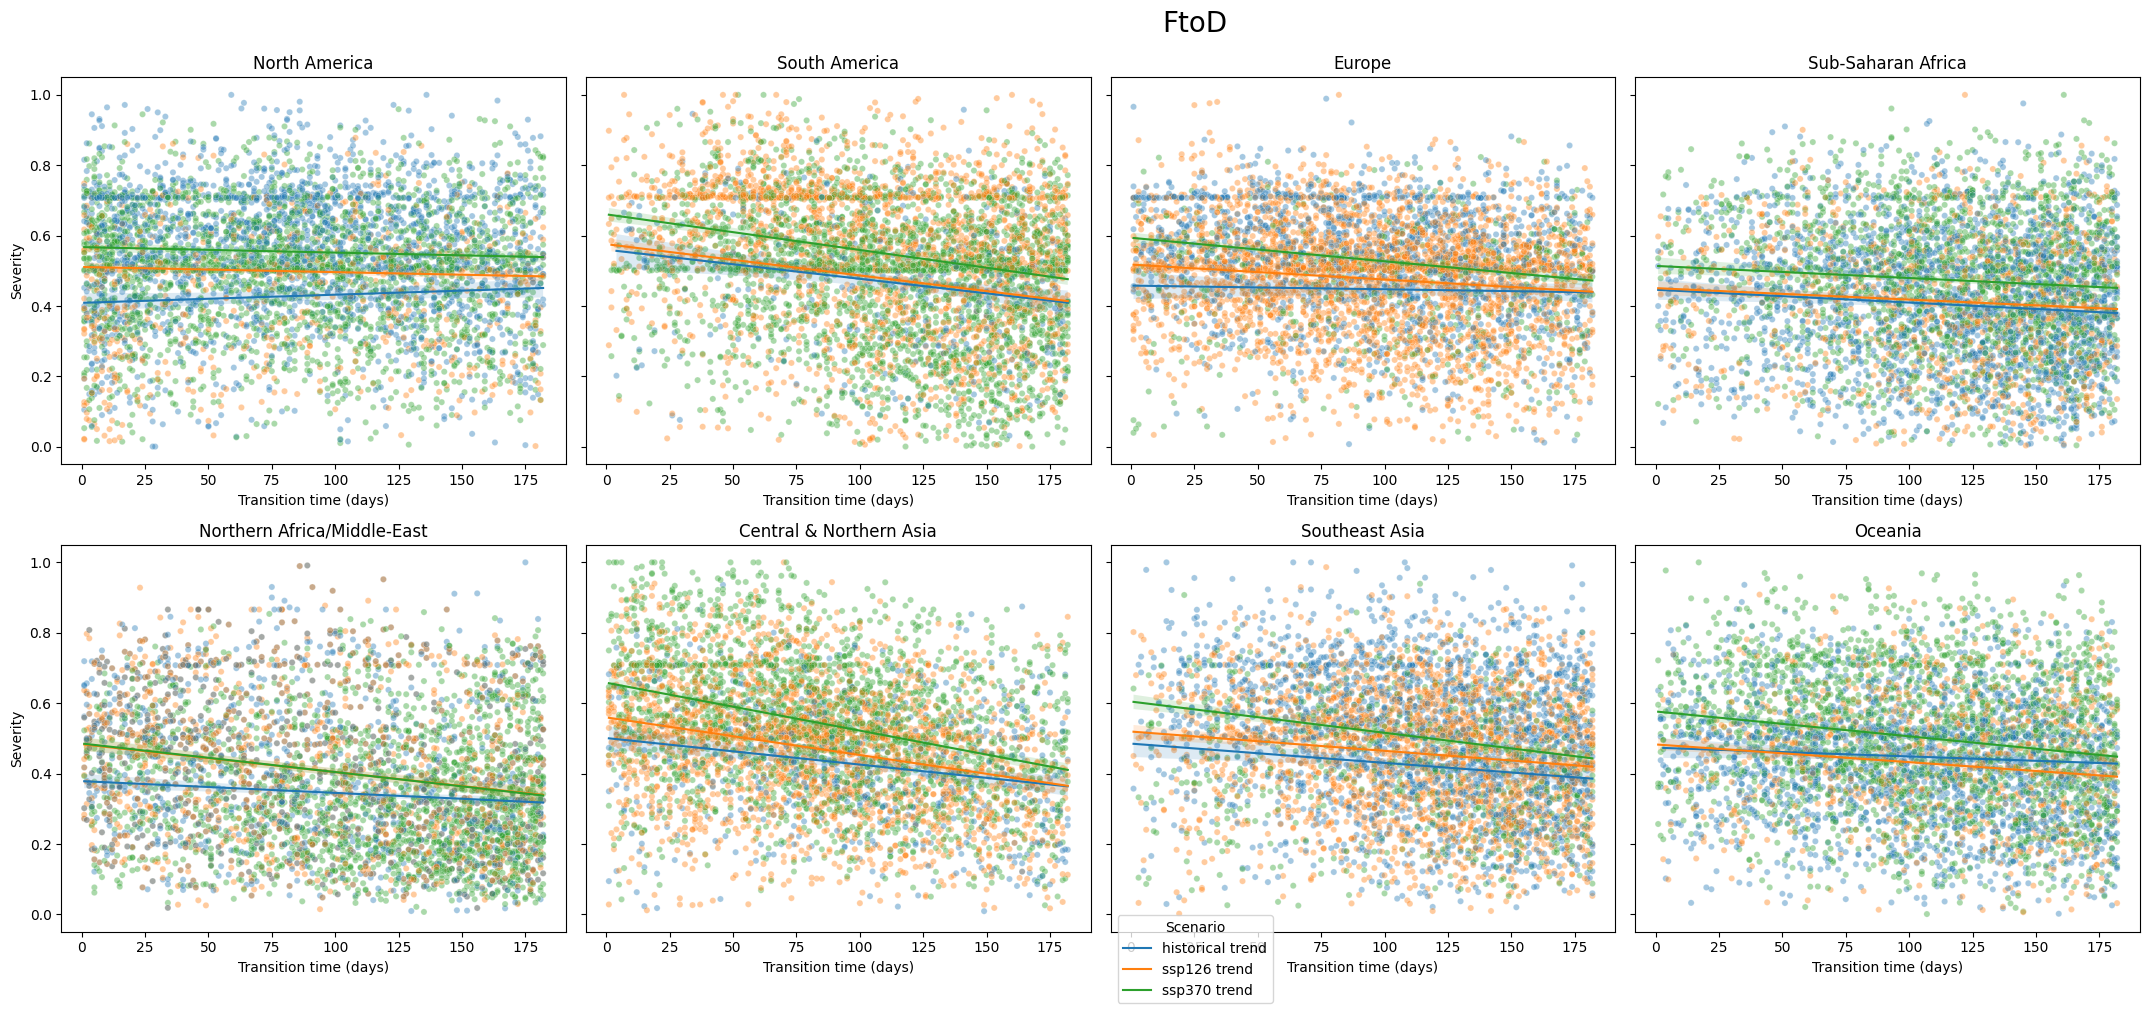

In [15]:
#create visualisations of abruptness-severity relationship

# Define region datasets
regions = {
    "North America": [historical_NA, ssp126_NA, ssp370_NA],
    "South America": [historical_SA, ssp126_SA, ssp370_SA],
    "Europe":       [historical_europe, ssp126_europe, ssp370_europe],
    "Sub-Saharan Africa": [historical_SSA, ssp126_SSA, ssp370_SSA],
    "Northern Africa/Middle-East": [historical_NA_ME, ssp126_NA_ME, ssp370_NA_ME],
    "Central & Northern Asia":     [historical_CNA, ssp126_CNA, ssp370_CNA],
    "Southeast Asia":              [historical_SEA, ssp126_SEA, ssp370_SEA],
    "Oceania":                     [historical_Oce, ssp126_Oce, ssp370_Oce]
}

scenarios = ["historical", "ssp126", "ssp370"]
event_types = ["DtoF", "FtoD"]

# Generate one figure per event type
for event_type in event_types:
    fig, axes = plt.subplots(2, 4, figsize=(24, 10), sharey=True)
    axes = axes.flatten()

    for idx, (region_name, datasets) in enumerate(regions.items()):
        ax = axes[idx]
        rows = []

        for scen_idx, ds in enumerate(datasets):
            scen = scenarios[scen_idx]

            sev_var = f"ECSI_sev_{event_type}"
            trans_var = f"transition_times_{event_type}"

            if sev_var in ds and trans_var in ds:
                sev_arr = ds[sev_var].values.ravel()
                trans_arr = ds[trans_var].values.ravel()

                # keep only pairs where both are finite
                mask = (~np.isnan(sev_arr)) & (~np.isnan(trans_arr))
                for s, t in zip(sev_arr[mask], trans_arr[mask]):
                    rows.append({
                        "Region":     region_name,
                        "Scenario":   scen,
                        "EventType":  event_type,
                        "Severity":   s,
                        "Transition": t
                    })

        # make DataFrame
        df = pd.DataFrame(rows)
        if df.empty:
            ax.set_title(region_name + "\n(no data)")
            continue

        # sample points if too many
        max_points = 5000
        if len(df) > max_points:
            df = df.sample(n=max_points, random_state=42)

        # scatter plot
        sns.scatterplot(
            data=df,
            x="Transition", y="Severity",
            hue="Scenario",
            ax=ax,
            alpha=0.4, s=20,
            legend=False
        )

        # add trend lines per scenario
        for scenario_name, group in df.groupby("Scenario"):
            sns.regplot(
                data=group,
                x="Transition", y="Severity",
                scatter=False,
                ax=ax,
                label=f"{scenario_name} trend",
                line_kws={"linewidth": 1.5}
            )
            

        ax.set_title(region_name)
        ax.set_xlabel("Transition time (days)")
        if idx % 4 == 0:
            ax.set_ylabel("Severity")
        else:
            ax.set_ylabel("")



    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.suptitle(f"{event_type}", y=0.98, fontsize=20)
    handles, labels = axes[0].get_legend_handles_labels()
    if event_type == "FtoD":
        fig.legend(
            handles, labels,
            loc='lower center',
            bbox_to_anchor=(0.5, -0.02),
            title="Scenario",
            frameon=True)
        
plt.show()


In [9]:
#compute spearman correlation coefficients between severity and abruptness for each region
from scipy.stats import spearmanr 

regions = {
    "North America": [historical_NA, ssp126_NA, ssp370_NA],
    "South America": [historical_SA, ssp126_SA, ssp370_SA],
    "Europe":       [historical_europe, ssp126_europe, ssp370_europe],
    "Sub-Saharan Africa": [historical_SSA, ssp126_SSA, ssp370_SSA],
    "Northern Africa/Middle-East": [historical_NA_ME, ssp126_NA_ME, ssp370_NA_ME],
    "Central & Northern Asia":     [historical_CNA, ssp126_CNA, ssp370_CNA],
    "Southeast Asia":              [historical_SEA, ssp126_SEA, ssp370_SEA],
    "Oceania":                     [historical_Oce, ssp126_Oce, ssp370_Oce]
}

scenarios = ["historical", "ssp126", "ssp370"]
event_types = ["DtoF", "FtoD"]

# Generate one figure per event type
for event_type in event_types:

    for idx, (region_name, datasets) in enumerate(regions.items()):
        rows = []

        for scen_idx, ds in enumerate(datasets):
            scen = scenarios[scen_idx]

            sev_var = f"ECSI_sev_{event_type}"
            trans_var = f"transition_times_{event_type}"

            if sev_var in ds and trans_var in ds:
                sev_arr = ds[sev_var].values.ravel()
                trans_arr = ds[trans_var].values.ravel()

                # keep only pairs where both are finite
                mask = (~np.isnan(sev_arr)) & (~np.isnan(trans_arr))
                for s, t in zip(sev_arr[mask], trans_arr[mask]):
                    rows.append({
                        "Region":     region_name,
                        "Scenario":   scen,
                        "EventType":  event_type,
                        "Severity":   s,
                        "Transition": t
                    })

        # make DataFrame
                df = pd.DataFrame(rows)
        # sample points if too many
                coef, pval = spearmanr(df["Transition"], df["Severity"])
                print(f"{region_name, event_type, scen}: Spearman r = {coef:.3f}, p = {pval:.3e}")



('North America', 'DtoF', 'historical'): Spearman r = -0.008, p = 3.549e-02
('North America', 'DtoF', 'ssp126'): Spearman r = 0.117, p = 0.000e+00
('North America', 'DtoF', 'ssp370'): Spearman r = 0.100, p = 0.000e+00
('South America', 'DtoF', 'historical'): Spearman r = -0.122, p = 1.445e-119
('South America', 'DtoF', 'ssp126'): Spearman r = -0.158, p = 0.000e+00
('South America', 'DtoF', 'ssp370'): Spearman r = -0.156, p = 0.000e+00
('Europe', 'DtoF', 'historical'): Spearman r = -0.026, p = 3.686e-05
('Europe', 'DtoF', 'ssp126'): Spearman r = 0.175, p = 0.000e+00
('Europe', 'DtoF', 'ssp370'): Spearman r = 0.159, p = 0.000e+00
('Sub-Saharan Africa', 'DtoF', 'historical'): Spearman r = -0.101, p = 5.854e-80
('Sub-Saharan Africa', 'DtoF', 'ssp126'): Spearman r = -0.210, p = 0.000e+00
('Sub-Saharan Africa', 'DtoF', 'ssp370'): Spearman r = -0.222, p = 0.000e+00
('Northern Africa/Middle-East', 'DtoF', 'historical'): Spearman r = -0.217, p = 5.423e-63
('Northern Africa/Middle-East', 'DtoF',

In [8]:

#regional analysis of ECSI values for each transition type, across scenarios.
regions = {
    "NA":        [historical_NA,  ssp126_NA,  ssp370_NA],
    "SA":        [historical_SA,  ssp126_SA,  ssp370_SA],
    "Europe":    [historical_europe, ssp126_europe, ssp370_europe],
    "SSA":       [historical_SSA, ssp126_SSA, ssp370_SSA],
    "NA_ME":     [historical_NA_ME, ssp126_NA_ME, ssp370_NA_ME],
    "CNA":       [historical_CNA,  ssp126_CNA,  ssp370_CNA],
    "SEA":       [historical_SEA,  ssp126_SEA,  ssp370_SEA],
    "Oce":       [historical_Oce,  ssp126_Oce,  ssp370_Oce]
}

scenario_names = ["historical", "ssp126", "ssp370"]

for region_name, ds_list in regions.items():
    for sc_name, ds in zip(scenario_names, ds_list):

        dtof_mean = ds['ECSI_sev_DtoF'].mean()
        dtofmod_mean = ds['ECSI_sev_DtoF_slow'].mean()
        dtofrap_mean = ds['ECSI_sev_DtoF_rapid'].mean()
        dtofabr_mean = ds['ECSI_sev_DtoF_abrupt'].mean()
        
        ftod_mean = ds['ECSI_sev_FtoD'].mean()
        ftodmod_mean = ds['ECSI_sev_FtoD_slow'].mean()
        ftodrap_mean = ds['ECSI_sev_FtoD_rapid'].mean()
        ftodabr_mean = ds['ECSI_sev_FtoD_abrupt'].mean()
        dandf_mean = ds['ECSI_sev_D&F'].mean().item()
        print(dandf_mean)
        # print(f"{region_name:8s} | {sc_name:10s} | DtoF all: {dtof_mean:3.2f} | DtoF slow: {dtofmod_mean:3.2f} | DtoF rap : {dtofrap_mean:3.2f}  | DtoF abr: {dtofabr_mean:3.2f} | FtoD: {ftod_mean:3.2f} | FtoD mod: {ftodmod_mean:3.2f} | FtoD rap: {ftodrap_mean:3.2f}| FtoD abr: {ftodabr_mean:3.2f}")

0.31471094767749774
0.4600373981187423
0.4344383890874002
0.36277224661545104
0.5119736492634577
0.5267197911497802
0.3555663245647562
0.5053149872049281
0.5463073938980497
0.3843136418150351
0.4678865713637659
0.46283391117804634
0.4447449039439342
0.4849810269188402
0.5347294663869828
0.3602139490087253
0.4846515704663137
0.5474357749949148
0.3851281638759699
0.45091013567041016
0.42709363648583265
0.3421415109344219
0.45681212031894447
0.4226081136502194


In [ ]:
# regional analysis of flood magnitude
scenario_names = ["historical", "ssp126", "ssp370"]

regions = {
    "NA":      [historical_NA,  ssp126_NA,  ssp370_NA],
    "SA":      [historical_SA,  ssp126_SA,  ssp370_SA],
    "Europe":  [historical_europe, ssp126_europe, ssp370_europe],
    "SSA":     [historical_SSA, ssp126_SSA, ssp370_SSA],
    "NA_ME":   [historical_NA_ME, ssp126_NA_ME, ssp370_NA_ME],
    "CNA":     [historical_CNA,  ssp126_CNA,  ssp370_CNA],
    "SEA":     [historical_SEA,  ssp126_SEA,  ssp370_SEA],
    "Oce":     [historical_Oce,  ssp126_Oce,  ssp370_Oce]
}

for region_name, ds_list in regions.items():
    for sc_name, ds in zip(scenario_names, ds_list):
        dtofmod_mean = ds['magnitude_flood_DtoF_mod'].mean()
        dtofrap_mean = ds['magnitude_flood_DtoF_rap'].mean()
        dtofabr_mean = ds['magnitude_flood_DtoF_abr'].mean()

        ftodmod_mean = ds['magnitude_flood_FtoD_mod'].mean()
        ftodrap_mean = ds['magnitude_flood_FtoD_rap'].mean()
        ftodabr_mean = ds['magnitude_flood_FtoD_abr'].mean()

        dandf_mean = ds['magnitude_flood_D&F'].mean()

        print(f"{region_name:8s} | {sc_name:10s} | "
              f"DtoF mod: {dtofmod_mean:6.2f} | "
              f"DtoF rap: {dtofrap_mean:6.2f} | "
              f"DtoF abr: {dtofabr_mean:6.2f} | "
              f"FtoD mod: {ftodmod_mean:6.2f} | "
              f"FtoD rap: {ftodrap_mean:6.2f} | "
              f"FtoD abr: {ftodabr_mean:6.2f} | "
              f"D&F: {dandf_mean:6.2f}")


In [5]:
#regional analysis of drought duration for all transition types across scenarios.
scenario_names = ["historical", "ssp126", "ssp370"]
regions = {
    "NA":        [historical_NA,  ssp126_NA,  ssp370_NA],
    "SA":        [historical_SA,  ssp126_SA,  ssp370_SA],
    "Europe":    [historical_europe, ssp126_europe, ssp370_europe],
    "SSA":       [historical_SSA, ssp126_SSA, ssp370_SSA],
    "NA_ME":     [historical_NA_ME, ssp126_NA_ME, ssp370_NA_ME],
    "CNA":       [historical_CNA,  ssp126_CNA,  ssp370_CNA],
    "SEA":       [historical_SEA,  ssp126_SEA,  ssp370_SEA],
    "Oce":       [historical_Oce,  ssp126_Oce,  ssp370_Oce]
}
for region_name, ds_list in regions.items():
    for sc_name, ds in zip(scenario_names, ds_list):
        dtofall_mean = ds['duration_DtoF'].mean()
        dtofmod_mean = ds['duration_DtoF_mod'].mean()
        dtofrap_mean = ds['duration_DtoF_rap'].mean()
        dtofabr_mean = ds['duration_DtoF_abr'].mean()

        ftodall_mean = ds['duration_FtoD'].mean()
        ftodmod_mean = ds['duration_FtoD_mod'].mean()
        ftodrap_mean = ds['duration_FtoD_rap'].mean()
        ftodabr_mean = ds['duration_FtoD_abr'].mean()
        
        dandf_mean = ds['duration_D&F'].mean()
        print(f"{region_name:8s} | {sc_name:10s} | DtoF all: {dtofall_mean:3.2f} | DtoF slow: {dtofmod_mean:3.2f} | DtoF rap : {dtofrap_mean:3.2f}  | DtoF abr: {dtofabr_mean:3.2f} | FtoD all: {ftodall_mean:3.2f} | FtoD mod: {ftodmod_mean:3.2f} | FtoD rap: {ftodrap_mean:3.2f}| FtoD abr: {ftodabr_mean:3.2f} | D&F: {dandf_mean:3.2f}")


NA       | historical | DtoF all: 65.29 | DtoF slow: 56.49 | DtoF rap : 72.68  | DtoF abr: 62.52 | FtoD all: 62.23 | FtoD mod: 76.82 | FtoD rap: 54.90| FtoD abr: 43.39 | D&F: 44.08
NA       | ssp126     | DtoF all: 60.37 | DtoF slow: 56.18 | DtoF rap : 68.79  | DtoF abr: 63.28 | FtoD all: 53.15 | FtoD mod: 54.95 | FtoD rap: 52.56| FtoD abr: 50.48 | D&F: 50.94
NA       | ssp370     | DtoF all: 66.45 | DtoF slow: 61.03 | DtoF rap : 77.91  | DtoF abr: 74.96 | FtoD all: 56.67 | FtoD mod: 58.13 | FtoD rap: 56.82| FtoD abr: 54.71 | D&F: 52.83
SA       | historical | DtoF all: 42.63 | DtoF slow: 43.10 | DtoF rap : 42.01  | DtoF abr: 40.33 | FtoD all: 43.44 | FtoD mod: 43.03 | FtoD rap: 43.95| FtoD abr: 44.82 | D&F: 53.65
SA       | ssp126     | DtoF all: 52.93 | DtoF slow: 52.54 | DtoF rap : 53.81  | DtoF abr: 53.19 | FtoD all: 53.36 | FtoD mod: 51.89 | FtoD rap: 57.18| FtoD abr: 56.15 | D&F: 53.47
SA       | ssp370     | DtoF all: 60.09 | DtoF slow: 59.74 | DtoF rap : 61.01  | DtoF abr: 57.5